<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Makemore/01_Makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore-01

A simple bigram character-level language model is implemented as a foundation for building more complex models like Transformers. The focus lies on two main aspects:

1. Efficient use of `torch.Tensor` for neural network computation
2. Core components of language modeling: training, sampling, and loss evaluation

**Key Steps:**

* Load and explore the dataset
* Count character bigrams using a dictionary and a 2D tensor
* Visualize the bigram probability matrix
* Clean the dataset by unifying start/end tokens
* Sample new text from the model
* Improve efficiency using tensor broadcasting and vectorized normalization
* Define the negative log likelihood loss function
* Apply model smoothing with fake counts

**Neural Network Extension:**

* Prepare a bigram dataset for a neural network
* Represent inputs as one-hot vectors
* Use a single linear layer (matrix multiplication) to predict the next character
* Apply softmax to produce probability distributions
* Compute a vectorized loss
* Perform backpropagation and parameter updates using PyTorch
* Reinterpret one-hot encoding as direct row selection in the weight matrix
* Add smoothing as a form of regularization
* Sample from the neural network model

This forms a minimal yet functional neural language model, setting the stage for future improvements.



# Load Dataset

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt -O names.txt

# words = open('sample_data/names.txt').read().splitlines()
words = open('names.txt').read().splitlines()
words[:10]

--2025-05-30 13:12:08--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-05-30 13:12:09 (6.10 MB/s) - ‘names.txt’ saved [228145/228145]



['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
len(words)

32033

In [ ]:
print(min(len(w) for w in words))
print(max(len(w) for w in words))

count = 0
for w in words:
  count+= 1
  for ch in w:
    count+=1
print(count)

2
15
228146


In [ ]:
print(min(words, key = len))
print(max(words, key = len))

an
muhammadibrahim


# Start with a Bigram Model

In [ ]:
# w: a list with all characters of that word
# w[1:]: same list but with the first character missing
# zip(w, w[:1]) creates tuples of two following characters by taking two iterators of the iterable objects like lists, strings, tuples

b = {}
for w in words:
  #print(w)
  #print(list(w))
  chs = ['<S>'] + list(w) + ['<E>']
  #print(chs)
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    # b.get(bigram, 0) -> if bigram not in b set value to 0 -> in every case: add 1 to its value
    b[bigram] = b.get(bigram, 0) + 1
    #print(ch1, ch2)

In [ ]:
#b
#sorted(b.items(), key = lambda kv: -kv[1])

# What we want is a 2 dimensional Array



- the rows are going to be the first character
- the collums are going to be the second character
- what is convinient to use: pytorch -> and then Tensors

# Preparing data

In [ ]:
import torch

In [ ]:
# as we use counts -> we gonna use 32 bit integer
a = torch.zeros((3,5), dtype = torch.int32)
a


tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [ ]:
a[1, 3] += 1
a[0, 0] += 5
a

tensor([[5, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [ ]:
N = torch.zeros((27,27), dtype = torch.int32)

In [ ]:
' _ '.join(['bubu', 'gigi', 'mimi'])

'bubu _ gigi _ mimi'

In [ ]:
chars = sorted(list(set(''.join(words))))
# s to i = string to index
# enumerate gives us an iterator over chars | i is the index | s is the element(character) of the list | then we are mapping the character to the integer
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0


In [ ]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    N[stoi[ch1], stoi[ch2]] += 1


In [ ]:
itos = {i:s for s,i in stoi.items()}

itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# The Chart 📊

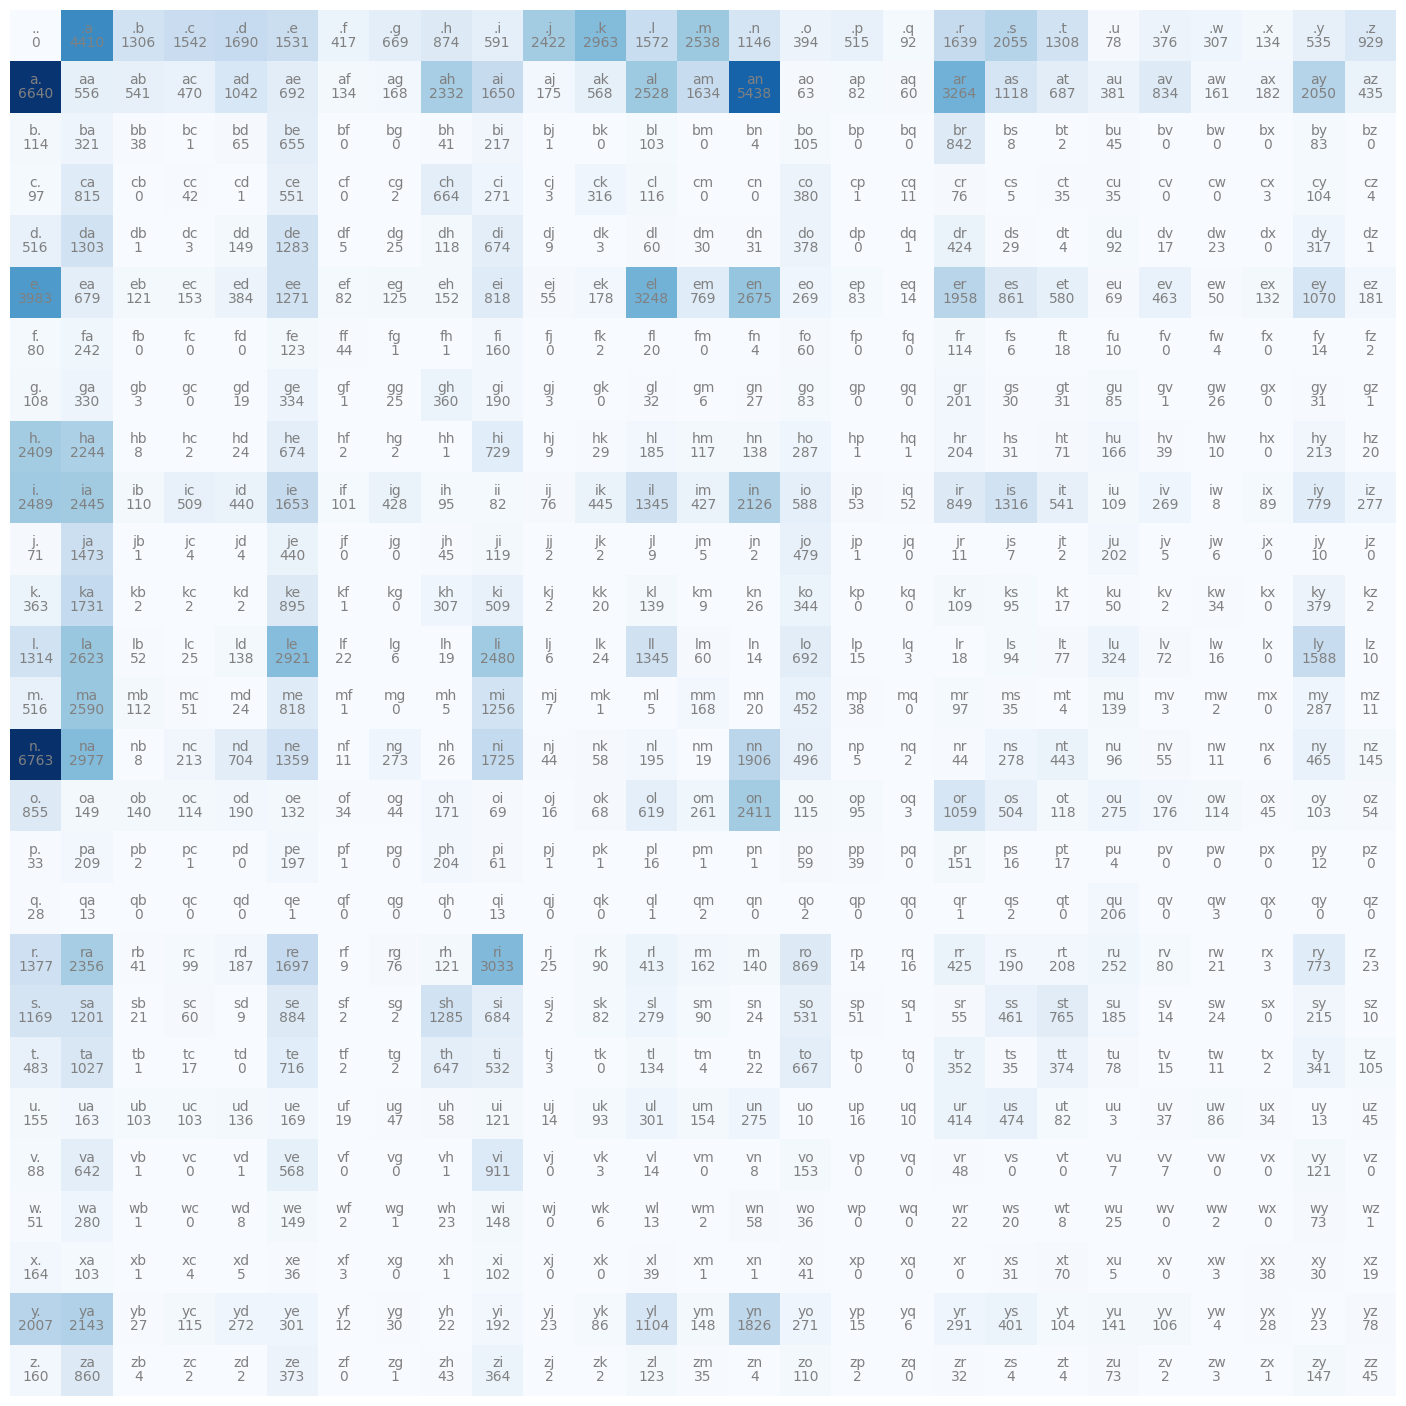

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,18))
plt.imshow(N, cmap='Blues')

for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    # i and j seams to be in wrong order, but matplot works with an cartesian system
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i, j].item(), ha ="center", va="top", color="gray")
plt.axis('off');


In [ ]:
N[0, :]
N[0, :].shape
# -> torch.Size([27])


torch.Size([27])

# Calculate Probability for every event

In [ ]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [ ]:
p.sum()
# = 1, as we devided every probability of an event by the totatl number of possible events

tensor(1.)

# Proceeding with torch.multinomial - small Example

- you give me probabilities and i give you intagers wich are sampled according to the propability distribution
- to make every think deterministic we use a generator object in pytorch
  - means: runs the same on every computer

In [ ]:
# generate genrator object and seed it with some number

g = torch.Generator().manual_seed(2147483647)
# creating 3 random objects between 0 and 1 depending on the generator object
# but because we are using the same generator, the generated numbers stay the same always
p = torch.rand(3, generator = g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [ ]:
# now use torch multinomial to draw samples from it
# replacement: if we draw an sample we can put it back to basket of possible elementary events

torch.multinomial(p, num_samples = 20, replacement=True , generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [ ]:
p.shape

torch.Size([3])

In [ ]:
t = torch.tensor([
    [1,2,3],
    [4,5,6]
    ])
print(t)
print(t.sum(dim=0))
# when not explicitly setting keepdim=True, then the dimension is squeezed out
print(t.sum(dim=1))
print(t.sum(dim=1, keepdim=True))


tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([5, 7, 9])
tensor([ 6, 15])
tensor([[ 6],
        [15]])


# Back to our dataset - setting Probability Values

## Understand shapes and operations

In [ ]:
p = N[0].float()
# print(p)

ColumnCount = []
for i in range(27):
  sumColumn = 0
  for n in N:
    sumColumn += n[i]
  ColumnCount.append(sumColumn.item())
print(ColumnCount)

rowCount = []
for i in range(27):
  sumRow = 0
  for j in range(27):
    sumRow += N[i][j]
  rowCount.append(sumRow.item())
print(rowCount)

p = p / p.sum()

g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

[32033, 33885, 2645, 3532, 5496, 20423, 905, 1927, 7616, 17701, 2900, 5040, 13958, 6642, 18327, 7934, 1026, 272, 12700, 8106, 5570, 3135, 2573, 929, 697, 9776, 2398]
[32033, 33885, 2645, 3532, 5496, 20423, 905, 1927, 7616, 17701, 2900, 5040, 13958, 6642, 18327, 7934, 1026, 272, 12700, 8106, 5570, 3135, 2573, 929, 697, 9776, 2398]


'j'

## Creating and Smoothing out the model P=(N+1).float
- laplace smoothing with adding int number to every entry like:
  - P=(N+1).float()
- the grater the value we add, the more we are smoothing out the model

In [ ]:
# We also do a little model smoothing: with (N+1) we add 1 to every cell of the table
P = (N+1).float()
print(P.shape)
# sum of all entries
print(P.sum())
# -> we have to dimensions

# get a row vector
#print(P.sum(dim = 0, keepdim=True))
print(P.sum(dim = 0, keepdim=True).shape)
#print('\n')

# get a column vector
#print(P.sum(dim = 1, keepdim=True))
print(P.sum(dim = 1, keepdim=True).shape)

#print('\n')
#  print(P.shape)

torch.Size([27, 27])
tensor(228875.)
torch.Size([1, 27])
torch.Size([27, 1])


P.sum() gives us the sum of all elements. so we have to torch.sum and search for the definition

## But can we devide a 27/27 Array by a 27/1 Array?

- this is dtermined by broadcasting rules: search for 'pytorch broadcasting semantics'


- If A has shape (27, 27) and B has shape (27, 1), then B will be broadcasted along the second dimension (columns).

### Broadcasting Behavior in A / B

- A: (27, 27)

- B: (27, 1)

- Since B has only one column, it will be automatically broadcasted across all 27 columns. This means each row of A will be divided element-wise by the corresponding element in B from the same row.


### Trailing Dimension?

- The trailing dimension (hintere dimension) is the last dimension that gets expanded due to broadcasting.

- In this case, B has a trailing dimension of 1, which is expanded to match the 27 columns of A.

In [ ]:
# this would create a new tensor:
#P = P / P.sum(1, keepdim=True)
#P[0].sum()

# for saving memory we use inplace operations:
#P/=P.sum(dim=1, keepdim=True)

# P: 27/27
# P.sum(dim = 1, keepdim = True) : 27/1
# P/ P.sum(dim=1, keepdim=True): every element of a row gets divided by the sum of a row

# now the sum of each row is 1.0
#for p in P:
#print(p.sum())
#P[0]

In [ ]:
# carefull with this one, we want to normalize by the rows, but we would normalite by the columns
# it's about broadcasting ruels going through the dimension form right to the left and if the dimension doesn't exist you create it

#P = P/P.sum(1)

#print(P[0].sum())

# syntax: select all rows at position 0 -> means: first column
#print(P[:, 0].sum())

## Clean Code Area

In [ ]:
P/=P.sum(dim=1, keepdim=True)


In [ ]:
g = torch.Generator().manual_seed(2147483647)

names = []

for i in range(30):
  out=[]

  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  names.append(out)

#for w in names:
#  print(''.join(w))

the output looks terrible. thats because bigrams are terrible :)

# Evaluate the Model - introducing negative average log lokelihood = creating a Loss Function
- for equal distrubution every value would have probablity of p1 = 1/27 = 0.037
- for any value with probability > p1 it means that we learned something

In [ ]:
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1][ix2]
    print(f'{ch1}{ch2}. {prob:.4f}')

.e. 0.0478
em. 0.0377
mm. 0.0253
ma. 0.3885
a.. 0.1958
.o. 0.0123
ol. 0.0779
li. 0.1774
iv. 0.0152
vi. 0.3508
ia. 0.1380
a.. 0.1958
.a. 0.1376
av. 0.0246
va. 0.2473
a.. 0.1958


## Go on with looking up Maximum likelihood estimation
- the product of all the listed probabilities is the likelihood
- for convinence as the value would be very small, we work with the log likelihood
- the reason behind:
  - a*b*c would just be a very small number
  - log(a*b*c) = log(a) + log(b) + log(c)

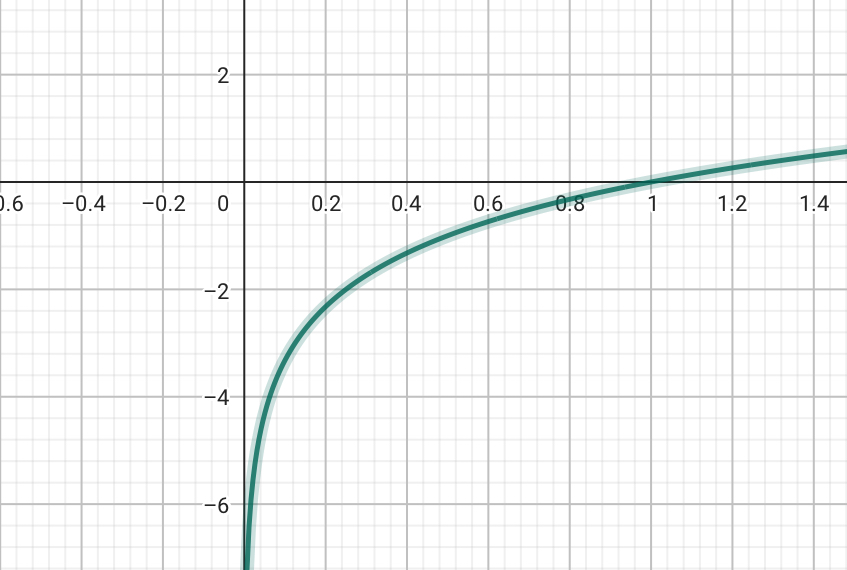

In [ ]:
log_likelihood = 0.0
n = 0

#for w in words:
for w in ["henninger"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1][ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood = }')

.h: 0.0273 -3.6011
he: 0.0883 -2.4268
en: 0.1309 -2.0337
nn: 0.1039 -2.2643
ni: 0.0940 -2.3640
in: 0.1200 -2.1204
ng: 0.0149 -4.2045
ge: 0.1714 -1.7635
er: 0.0958 -2.3455
r.: 0.1083 -2.2231
log_likelihood = tensor(-25.3470)


## What we don't like so far - Why we need the negative log likelihood for the Loss function

- we can't use that for a loss function as low means good
- we need to invert this

In [ ]:
nll = -log_likelihood
print(f'{nll = }')

nll = tensor(25.3470)


In [ ]:
# get the normalized negative log likelihood
# means we get the average (negative) log likelihood
print(f'{nll/n}')

2.5347042083740234


...this number represents the quality of our model
- the lower it is, the better off we are
- the higher, the worse off we are

Our job:
- find the parameters that minimize the (average) negative log likelihood loss
- equivalent to: maximise the log likelihood loss
- equivalent to. maximise the likelihood of the data

In [ ]:
log_likelihood2 = 0.0
n2 = 0

#for w in words:
for w in ["hanno"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1][ix2]
    logprob = torch.log(prob)
    log_likelihood2 += logprob
    n2 += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood2 = }')
nll2 = -log_likelihood2
print(f'{nll2=}')
print(f'{nll2/n2}')

.h: 0.0273 -3.6011
ha: 0.2937 -1.2251
an: 0.1604 -1.8302
nn: 0.1039 -2.2643
no: 0.0271 -3.6090
o.: 0.1075 -2.2300
log_likelihood2 = tensor(-14.7598)
nll2=tensor(14.7598)
2.459961175918579


# Train a NN for prediction 🤖

## Create a training set for all the bigrams

In [ ]:
xs, ys = [], []

for w in words[:1]:
  #print(w)
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

## Give int values to a neural NN via one-hot encoding
- create a vektor with the size of the char set (all classes) with all values zero: (0, 0, ...)
- then turn the class value of the vector to 1
- pytorch already has a ONE_HOT functionality

In [ ]:
import torch.nn.functional as F

### Turn all exmaples into vectors

In [ ]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc.shape

torch.Size([5, 27])

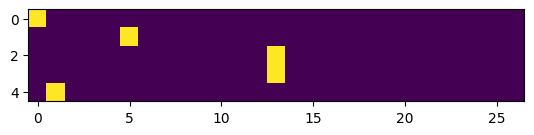

In [ ]:
plt.imshow(xenc)

### When plugging in numbers into a NN we don't want them to be integers, we want them to be floating point numbers that can take on various values

In [ ]:
# We did cast the values to float earlier ;)
xenc.dtype

torch.float32

## Weight Initialization

### Start with creating random weights for the input
- using torch.randn

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)
# @: a matrix multiplication operator in pytorch
# xenc @ W

What we did here was (5, 27) @ (27,1):
- so the output will become (5,1)
- ...as the 27 will multiply and add

What we want is this:
- (5, 27) @ (27,27) -> (5,27)

###The firing rate

In [ ]:
#W = torch.randn(27,27)
# xenc @ W

The result tells us what is the firing rate of those neurons on every one of those five examples

In [ ]:
# tells us the firing rate of the 13th neuron looking at the 3rd input
#(xenc@W)[3,13]


In [ ]:
# xenc[3]

In [ ]:
# W

In [ ]:
# all rows at colun 13
W[:,13]

tensor([-4.3297e-01, -9.6478e-01,  2.1346e+00, -7.2759e-01, -1.3753e-01,
        -1.3132e-03, -3.1566e-01,  1.1199e+00, -4.7701e-01, -1.5065e+00,
         1.2108e+00, -4.0636e-01,  1.9110e-01,  3.7882e-02,  1.3431e+00,
         2.4311e-01, -1.5364e-01, -1.1583e+00,  1.1614e+00,  4.2016e-01,
         2.7359e-01,  3.6583e-01,  1.7128e+00,  1.3769e+00, -8.9778e-01,
        -9.5177e-01,  1.4723e-01])

In [ ]:
#this one is more rigth
(xenc[3]*W[:,13]).sum()


tensor(0.0379)

In [ ]:
#lucky that this one worked ;)
(xenc[3]*W[13]).sum()

tensor(0.0379)

### How to evaluate the inputs - working with log counts and exp(x)
- plugging in numbers > 0 we get outputs > 1 (growing to infinity)
- plugging in numbers < 0 we get outputs < 1 (decreasing to zero)

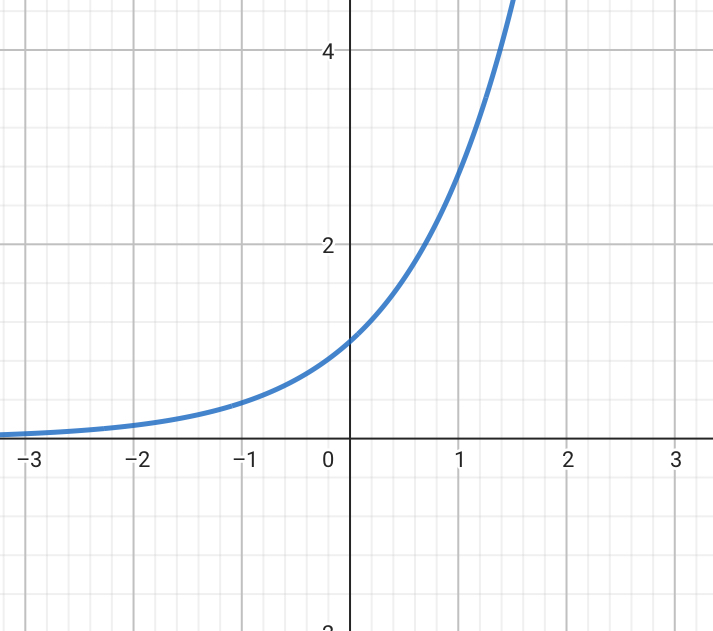

## Make all numbers positive and design a Loss function
- so it looks more usefull for predicting as the numbers are similar to the counts in the chart before
  - high number means high emission probability
- we are going to normalize the weights of our vektors
- m*n Matrix
  - m = row = dim0
  - n = column = dim1

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)

In [ ]:
# (xenc @ W).exp()
logits = xenc @ W # log-counts
counts = logits.exp() # equilvalent to the N matrix // but they just look like counts
probs = counts / counts.sum( dim=1, keepdim = True) # normalized weights of vectors

In [ ]:
logits[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046, -0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,
         1.5618, -1.6261,  0.6772, -0.8404,  0.9849, -0.1484, -1.4795,  0.4483,
        -0.0707,  2.4968,  2.4448])

In [ ]:
counts[0]

tensor([ 4.7940,  0.7888,  0.9730,  0.3326,  1.3309,  0.9708,  0.2129,  1.8311,
         1.0824,  2.4710,  0.6242,  2.1964,  0.7200,  0.6486,  3.9469, 18.7908,
         4.7673,  0.1967,  1.9683,  0.4315,  2.6775,  0.8621,  0.2277,  1.5656,
         0.9317, 12.1434, 11.5281])

In [ ]:
probs[0]

tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])

In [ ]:
liste = zip( sorted(logits[0]), sorted(counts[0]), sorted(probs[0]))
for  b in liste:
  print(b)

(tensor(-1.6261), tensor(0.1967), tensor(0.0025))
(tensor(-1.5471), tensor(0.2129), tensor(0.0027))
(tensor(-1.4795), tensor(0.2277), tensor(0.0029))
(tensor(-1.1008), tensor(0.3326), tensor(0.0042))
(tensor(-0.8404), tensor(0.4315), tensor(0.0055))
(tensor(-0.4713), tensor(0.6242), tensor(0.0079))
(tensor(-0.4330), tensor(0.6486), tensor(0.0082))
(tensor(-0.3284), tensor(0.7200), tensor(0.0091))
(tensor(-0.2373), tensor(0.7888), tensor(0.0100))
(tensor(-0.1484), tensor(0.8621), tensor(0.0109))
(tensor(-0.0707), tensor(0.9317), tensor(0.0118))
(tensor(-0.0296), tensor(0.9708), tensor(0.0123))
(tensor(-0.0274), tensor(0.9730), tensor(0.0123))
(tensor(0.0791), tensor(1.0824), tensor(0.0137))
(tensor(0.2859), tensor(1.3309), tensor(0.0168))
(tensor(0.4483), tensor(1.5656), tensor(0.0198))
(tensor(0.6049), tensor(1.8311), tensor(0.0232))
(tensor(0.6772), tensor(1.9683), tensor(0.0249))
(tensor(0.7868), tensor(2.1964), tensor(0.0278))
(tensor(0.9046), tensor(2.4710), tensor(0.0313))
(tensor

- all operations we used here are diffrentiable -> so we can backpropagate through them
- calculating counts and probs is called the softmax
  - it just means exponentiating (make all numbers non zero) an then normalize all values
  - $\frac{{e}^z_j}{\sum_{j=1}^{k}{e}^z_j}$ -> just a normalization function/ nothing scary ;D
    - you can put it on any linear layer and it outputs probabilities

In [ ]:
# probs.sum(dim=1)

In [ ]:
probs.shape

torch.Size([5, 27])

- what this tells us is the NN assignment of how likely each of those characters are to come next
- the question:
  - can we find a good W so that the probabilities coming out are pretty good
  - the way we meassure 'pretty googd' is THE LOSS function

- for the following exmaples remember:
  - high negative log likelihood means 'HIGH LOSS'

...means: high probability gives us a low negative log likelihood

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram
  x = xs[i].item() # input character index
  y = ys[i].item() # output character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
  print('input to the neural net:', x)
  print('output probabilitis from the neural net:', probs[i])
  print('label (actual next character): ', y)
  p = probs[i][y]
  print('probability assigned by the net to the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood: ', logp.item())
  nll = -logp
  print('negative log likelihood: ', nll.item())
  nlls[i] = nll

print('=======')
print('average negative log likelihood, i.e. loss:', nlls.mean().item())

--------
bigram example 1: .e (indexes 0, 5)
input to the neural net: 0
output probabilitis from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character):  5
probability assigned by the net to the correct character: 0.01228625513613224
log likelihood:  -4.399273872375488
negative log likelihood:  4.399273872375488
--------
bigram example 2: em (indexes 5, 13)
input to the neural net: 5
output probabilitis from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character):  13
probability assigned by the net to the correct character: 0.0180

- the average negative log likelihood is our LOSS
  - to get another W we can manipulate the generator by +1
  - ...but the way to just generate datasets and test them is 'amateur hour'

## Next step: Optimization/ tuning W (weights matrix)
- minimizing the Loss
  - tuning W by computing the gradients of the Loss with repspect to the W matrices
- everything now looks a lot similar to the micrograd example but
  - in micro grad:
    - regression
    - using mean squared error for the loss
  - in this example:
    - classification
    - using the negative log likelihood

### First time trying - Weigth tuning with calculating loss and backpropagation

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g, requires_grad = True)

In [ ]:
W.shape


torch.Size([27, 27])

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes = 27). float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equvivalent to N
probs = counts / counts.sum(dim =1, keepdim=True) # probabilities for next character

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:
#probs we are looking up
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]

(tensor(0.0123, grad_fn=<SelectBackward0>),
 tensor(0.0181, grad_fn=<SelectBackward0>),
 tensor(0.0267, grad_fn=<SelectBackward0>),
 tensor(0.0737, grad_fn=<SelectBackward0>),
 tensor(0.0150, grad_fn=<SelectBackward0>))

In [ ]:
# what we want is to put those probabilities into a vector
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [ ]:
probs[torch.arange(5), ys]

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>)

In [ ]:
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.7693, grad_fn=<NegBackward0>)

In [ ]:
# backward pass

W.grad = None # here we do not set the gradients to 0 but to None
# backward only works if require_grad = True
# kind of magic as pytorch keeps track of all operations under the hood -> it builts a full computational graph
loss.backward()

In [ ]:
# tells us the influence of the weights on the loss function
# W.grad

In [ ]:
W.data += -0.1 * W.grad
loss = -probs[torch.arange(5), ys].log().mean()


In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes = 27). float() # input to the network: one-hot encoding«
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equvivalent to N
probs = counts / counts.sum(dim =1, keepdim=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
W.grad = None
loss.backward()
W.data += -0.1 * W.grad

In [ ]:
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.7492, grad_fn=<NegBackward0>)

### Clean code area - Same example with better overview


In [ ]:
print(words[:1])

['emma']


In [ ]:
# create dataset
xs, ys = [],[]
#print(words[:1])
for w in words:
  chs = ['.'] + list(w) + ['.']
  #print(chs_list)
  for ch1, ch2 in zip(chs, chs[1:]):
    #print(ch1, ch2)
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
# print(xs)
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad= True)

number of examples:  228146


At the end of optimization:
- the Arra W is the same as our array N from the bigram
- exept we arrived at it piece by piece by following the loss

Regularization:
- how to to uniform weights as in the bigramm model as: P=(N+1000).float()
  - initialize W with zeros
  - then W.exp() will be filled all with zeros
  - -> so bringing all values closer to zero is equivalent to label smoothing
- this concept is also called regularization loss

In [ ]:
print(W.mean())
# no negative value anymore
print((W**2).mean())

tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.9665, grad_fn=<MeanBackward0>)


In [ ]:
# gradient decent
for k in range(100):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  #logits gonna be the rows of W depending wich classes the one-hot codings define
  #more or less those are the emission probabilites for the transitions - after getting counts and then probs
  logits = xenc @ W # predict log-counts
  # logits is counts.log(): W exponentiated W.exp() is the Bigram Array N
  counts = logits.exp() # counts, eqvivalent to N
  # which neuron will activate most likely for the input class
  probs = counts / counts.sum(dim = 1, keepdims = True)
  # With addition of + 0.01*(W**2).mean() the model now tries to make all weigths zeros for minimizing the loss (works like a spring force)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  #update
  #W.data += -0.1 * W.grad
  W.data += -50 * W.grad



3.7686190605163574
3.3788068294525146
3.16109037399292
3.0271859169006348
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794439315796
2.5886809825897217
2.5822560787200928
2.5764293670654297
2.5711236000061035
2.566272735595703
2.5618228912353516
2.5577263832092285
2.5539441108703613
2.5504424571990967
2.5471925735473633
2.5441696643829346
2.5413522720336914
2.538722038269043
2.536262035369873
2.5339581966400146
2.5317976474761963
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243701934814453
2.522773265838623
2.52126407623291
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148375034332275
2.5137407779693604
2.512697696685791
2.511704921722412
2.5107581615448
2.509854793548584
2.5089924335479736
2.5081682205200195
2.50738024711608

### Now let's sample from the model

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:
    # -----
    # Before
    #p = P[ix]
    # -----
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes = 27). float() # input to the network: one-hot encoding«
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equvivalent to N
    p = counts / counts.sum(dim =1, keepdim=True) # probabilities for next character
    # -----

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator = g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


In [ ]:
import torch
a = torch.arange(18)
a
a.storage()
a.untyped_storage()

 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 2
 0
 0
 0
 0
 0
 0
 0
 3
 0
 0
 0
 0
 0
 0
 0
 4
 0
 0
 0
 0
 0
 0
 0
 5
 0
 0
 0
 0
 0
 0
 0
 6
 0
 0
 0
 0
 0
 0
 0
 7
 0
 0
 0
 0
 0
 0
 0
 8
 0
 0
 0
 0
 0
 0
 0
 9
 0
 0
 0
 0
 0
 0
 0
 10
 0
 0
 0
 0
 0
 0
 0
 11
 0
 0
 0
 0
 0
 0
 0
 12
 0
 0
 0
 0
 0
 0
 0
 13
 0
 0
 0
 0
 0
 0
 0
 14
 0
 0
 0
 0
 0
 0
 0
 15
 0
 0
 0
 0
 0
 0
 0
 16
 0
 0
 0
 0
 0
 0
 0
 17
 0
 0
 0
 0
 0
 0
 0
[torch.storage.UntypedStorage(device=cpu) of size 144]